In [1]:
#import sys
import matplotlib.animation as animation
#import time
import pylab as pl
from IPython import display

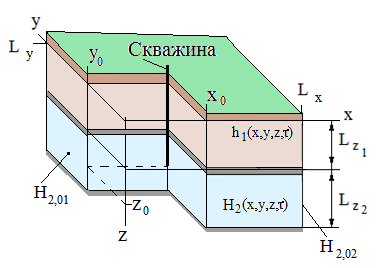

In [2]:
from IPython.display import Image
import matplotlib.pyplot as plt
Image("img_borning_place.png")

In [3]:
# Входные данные. Задаём номер варианта
N = 20
# 
Lx = 250 + 10*N
Ly = 200
Lz1 = 80 + N
Lz2 = 50 + 10*N

# начальные состояния невозмущенных грунтовых вод
H_201 = Lz1 + 10 + N #  м
H_202 = H_201 - 25
dH = H_201 - H_202
n = 25
om = 0.00001 #c-1

In [4]:
dH

25

In [5]:
print('Геометрические данные:  ','Lx = ',Lx,'  ','Ly = ',Ly,'  ','Lz1 = ',Lz1,'  ','Lz2 = ',Lz2,)

Геометрические данные:   Lx =  450    Ly =  200    Lz1 =  100    Lz2 =  250


In [6]:
# вычисление числа точек дискретизации по координатам
Nx = 9
Ny = 9
Nz1 = 9
Nz2 = 9

# Средняя точка водоносного пласта ?????????
x0 = 5 #Lx/2
y0 = 5 #Ly/2
z0 = 5 #Lz2/2

# Добывающая скважина осуществляет забор гидроминерального сырья «точке»
#Nx0 = 7
#Ny0 = 11
#Nz20 = 5

# Шаги дисретизации заданы
def step_d(L, N):
    return L/(N-1)

dx = step_d(Lx,Nx)
dy = step_d(Ly,Ny)
dz1 = step_d(Lz1,Nz1)
dz2 = step_d(Lz2,Nz2)


ch = 3600*24
# Дебит рассматриваемой скважины
Q = -100/ch# m^2/сут
K = 0.001 #0.00191487*0.8847618*1.8196176619 # 0.001
V = K*Q

# Коэффициенты фильтрациии по соответствующим координатам
kx = [0.198/ch, 0.146/ch]
ky = [0.196/ch, 0.148/ch]
kz = [0.148/ch, 0.024/ch]

# упругоемкость пласта
nu = 0.000581

# параметр перетекания, сут^(-1)
b1 = 0.0000035/ch 

In [7]:
K

0.001

In [8]:
def dirac_delta_function(x, y, z):
    return (1 if x == x0 and y == y0 and z == z0 else 0)

In [9]:
# задание переменной по нарзану
h = [[[0]*Nz1]*Ny]*Nx

# задание переменной по грунтовым водам
H = [[[0]*Nz2]*Ny]*Nx
Hk = [[[0]*Nz2]*Ny]*Nx

del_h = [[[0]*Nz1]*Ny]*Nx
del_H = [[[0]*Nz2]*Ny]*Nx

In [10]:
H0 = H_201

for j in range(0,Ny,1):
    for s in range(0,Nz2,1):
        for i in range(0,Nx,1):
            #Hk[i][j][s] = 
            H[i][j][s] = H_201 - dH*i/(Nx-1)
            print(H[i][j][s])
for i in range(0,Nx,1):
    for j in range(0,Ny,1):       
        for s in range(0,Nz1,1):
            h[i][j][s] = (s)*dz1

130.0
126.875
123.75
120.625
117.5
114.375
111.25
108.125
105.0
130.0
126.875
123.75
120.625
117.5
114.375
111.25
108.125
105.0
130.0
126.875
123.75
120.625
117.5
114.375
111.25
108.125
105.0
130.0
126.875
123.75
120.625
117.5
114.375
111.25
108.125
105.0
130.0
126.875
123.75
120.625
117.5
114.375
111.25
108.125
105.0
130.0
126.875
123.75
120.625
117.5
114.375
111.25
108.125
105.0
130.0
126.875
123.75
120.625
117.5
114.375
111.25
108.125
105.0
130.0
126.875
123.75
120.625
117.5
114.375
111.25
108.125
105.0
130.0
126.875
123.75
120.625
117.5
114.375
111.25
108.125
105.0
130.0
126.875
123.75
120.625
117.5
114.375
111.25
108.125
105.0
130.0
126.875
123.75
120.625
117.5
114.375
111.25
108.125
105.0
130.0
126.875
123.75
120.625
117.5
114.375
111.25
108.125
105.0
130.0
126.875
123.75
120.625
117.5
114.375
111.25
108.125
105.0
130.0
126.875
123.75
120.625
117.5
114.375
111.25
108.125
105.0
130.0
126.875
123.75
120.625
117.5
114.375
111.25
108.125
105.0
130.0
126.875
123.75
120.625
117.5
114.3

In [11]:
H

[[[105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0],
  [105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0],
  [105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0],
  [105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0],
  [105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0],
  [105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0],
  [105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0],
  [105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0],
  [105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0]],
 [[105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0],
  [105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0],
  [105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0],
  [105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0],
  [105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0],
  [105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 10

In [ ]:
dtau = 1
tau = 1000
start_t = 0
ans = []
time_in_day = []
ans2 = []#[0]*tau*10

index = 0

for t in range (start_t,tau):
    #t = t + dtau
    index = index + 1
    for i in range(1, Nx-1, 1):
        for j in range(1, Ny-1,1):
            for s in range(1, Nz1-1,1):            
                del_H[i][j][s] = dtau/nu*(kx[1]*(H[i-1][j][s]-2*H[i][j][s]+H[i+1][j][s])/dx/dx
                                           +ky[1]*(H[i][j-1][s]-2*H[i][j][s]+H[i][j+1][s])/dy/dy
                                           +kz[1]*(H[i][j][s-1]-2*H[i][j][s]+H[i][j][s+1])/dz1/dz1)
                +V*dirac_delta_function(i,j,s)
                #print(del_H[i][j][s])
                
                
            for s in range(1,Nz2-1,1):
                del_h[i][j][s] = dtau*((kx[0]*h[i-1][j][s]-2*h[i][j][s]+h[i+1][j][s])/dx/dx 
                                        +(ky[0]*h[i][j-1][s]-2*h[i][j][s]+h[i][j+1][s])/dy/dy
                                        +(kz[0]*h[i][j][s-1]-2*h[i][j][s]+h[i][j][s+1])/dz2/dz2)


    for i in range(1, Nx, 1):
        for j in range(1, Ny,1):
            for s in range(1, Nz1,1):
                H[i][j][s] = H[i][j][s] + del_H[i][j][s]
            for s in range(1, Nz2, 1):
                h[i][j][s] = h[i][j][s] + del_h[i][j][s]
            H[i][j][Nz2-1] = H[i][j][Nz2-2]
    
    
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            h[i][j][Nz1-1] = h[i][j][Nz1-1] + b1*dtau*(H[i][j][0] - h[i][j][Nz1-1])
            H[i][j][0] = H[i][j][0] - b1*dtau*(H[i][j][0] - h[i][j][Nz1-1])
    
    #ans[t] = H[x0][y0][z0]#ans.append(H[x0][y0][z0])#Hk[x0][y0][z0]-H[x0][y0][z0]
    time_in_day.append(t/3600/24)
    ans2.append(H[x0][y0][z0])#H[x0][y0][z0]-Hk[x0][y0][z0]
    print(H[x0][y0][z0])
    # для построения графика
    #plt.clf()
    #plt.plot(time_in_day,ans2)
    #display.clear_output(wait=True)
    #display.display(pl.gcf())
    # time.sleep(0.001)

In [ ]:
H

In [ ]:
top = range(0,index)
time_in_day = []
time_in_day = list(map(lambda x: x/3600/24, top))

In [ ]:
plt.plot(time_in_day,ans2)
#plt.xlim((-0.02,0.02))